# GPX raw data import results
This notebook presents a resume of the GPX loaded data.

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gpxpy
import gpxpy.gpx
from fiona.crs import from_epsg
from keplergl import KeplerGl
import geopandas as gpd
import movingpandas as mpd
import uuid
import hvplot.pandas
from pyproj import CRS


In [63]:
# this cell has been tagged with "parameters"

# Having the fetching code in the parameters cell allows dagster to overwrite this cell and replace
# it with the contents of the upstream dataset asset. If you want to run the notebook locally, this
# cell will remain, which allows you to fetch the dataset directly.

#file_path = '../data/MG91/MG91_ artefacto_reloj_20230505_01.gpx'
file_path = '../../data/MG91/MG91_artefacto_reloj_20230428_01.gpx'
# file_path = '../data/LH52/LH52_persona_reloj_20230425.gpx'
with open(file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

file_name = file_path.split("/")[-1]
track_id = file_name.split(".")[0]
route_info = []

codigo = track_id.split("_")[0]
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                    'lat': point.latitude,
                    'lon': point.longitude,
                    'elevation': point.elevation,
                    'time': point.time,
                    'file_path': file_path,
                    'fila_name': file_name,
                    'track_id': track_id,
                    'codigo': codigo,
                    'id': 1,
            })

route_df = pd.DataFrame(route_info)
gdf = gpd.GeoDataFrame(
    route_df, geometry=gpd.points_from_xy(route_df.lon, route_df.lat), crs=from_epsg(4326))

data = gdf



## Raw data import

In [64]:

print("This dataset contains {} records.\nThe first lines are:".format(len(data)))
data.head()

This dataset contains 8000 records.
The first lines are:


,lat,lon,elevation,time,file_path,fila_name,track_id,codigo,id,geometry
0,-2.895220,-78.986263,None,2023-04-28 07:30:57+00:00,../../data/MG91/MG91_artefacto_reloj_20230428_...,MG91_artefacto_reloj_20230428_01.gpx,MG91_artefacto_reloj_20230428_01,MG91,1,POINT (-78.98626 -2.89522)
1,-2.895220,-78.986260,None,2023-04-28 07:30:58+00:00,../../data/MG91/MG91_artefacto_reloj_20230428_...,MG91_artefacto_reloj_20230428_01.gpx,MG91_artefacto_reloj_20230428_01,MG91,1,POINT (-78.98626 -2.89522)
2,-2.895220,-78.986260,None,2023-04-28 07:30:59+00:00,../../data/MG91/MG91_artefacto_reloj_20230428_...,MG91_artefacto_reloj_20230428_01.gpx,MG91_artefacto_reloj_20230428_01,MG91,1,POINT (-78.98626 -2.89522)
3,-2.895220,-78.986258,None,2023-04-28 07:31:00+00:00,../../data/MG91/MG91_artefacto_reloj_20230428_...,MG91_artefacto_reloj_20230428_01.gpx,MG91_artefacto_reloj_20230428_01,MG91,1,POINT (-78.98626 -2.89522)
4,-2.895217,-78.986260,None,2023-04-28 07:31:01+00:00,../../data/MG91/MG91_artefacto_reloj_20230428_...,MG91_artefacto_reloj_20230428_01.gpx,MG91_artefacto_reloj_20230428_01,MG91,1,POINT (-78.98626 -2.89522)


In [65]:
data.columns

Index(['lat', 'lon', 'elevation', 'time', 'file_path', 'fila_name', 'track_id',
       'codigo', 'id', 'geometry'],
      dtype='object')

In [66]:
data.dtypes

lat                                float64
lon                                float64
elevation                           object
time         datetime64[ns, SimpleTZ("Z")]
file_path                           object
fila_name                           object
track_id                            object
codigo                              object
id                                   int64
geometry                          geometry
dtype: object

In [67]:
data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

##  Geographic extent

In [68]:
data.hvplot(title='Geographic extent of the dataset', geo=True, tiles='OSM', frame_height=450)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]

In [69]:
code = data['codigo'].unique()[0]

temp = data.to_crs(CRS(32717))
temp['geometry'] = temp['geometry'].buffer(5)
total_area = temp.dissolve(by='codigo').area 
total_area = total_area[code]/1000
print('The total area covered by the data is: {:,.2f} km2'.format(total_area))

The total area covered by the data is: 63.77 km2


## Temporal extent:

In [70]:
print("The dataset covers the time between {} and {}.".format(data.time.min(), data.time.max()))


The dataset covers the time between 2023-04-28 07:30:57+00:00 and 2023-04-28 09:44:16+00:00.


In [71]:
print("That's {}".format(data.time.max() - data.time.min()))


That's 0 days 02:13:19


## Number of registers each 10 minutes

Each complete 10m interval should have 600 counts, except first and last

<Axes: xlabel='time'>

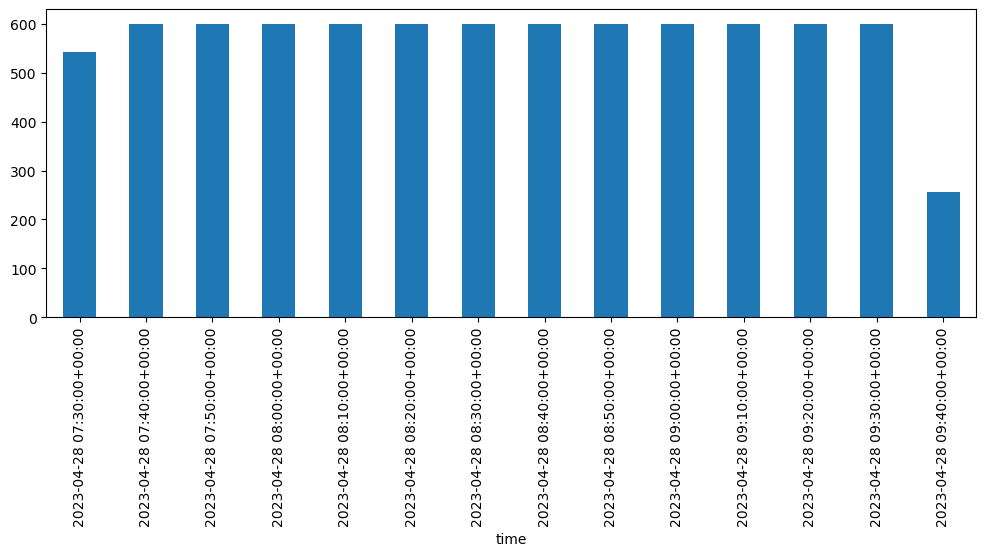

In [72]:
ig, axs = plt.subplots(figsize=(12, 4))

df = data
df.set_index('time')
df.groupby(pd.Grouper(key='time', axis=0, 
                      freq='10min'))["id"].sum().plot(kind='bar',  ax=axs)



## Sampling intervals

As the tracking gps are sensing with a resolution of 1s we expect to have records only in 1 second interval

In [73]:
t = data.reset_index().time
df = data.assign(delta_t=t.diff().values)
df['delta_t'] = df['delta_t'].dt.total_seconds()
pd.DataFrame(df).hvplot.hist('delta_t', title='Histogram of intervals between consecutive records (in seconds)', bins=60, bin_range=(0, 60))


:Histogram   [delta_t]   (delta_t_count)

## Spped values
For example: Does the data contain unattainable speeds?


In [75]:
traj = mpd.Trajectory(data, traj_id='id', t='time')

traj.add_speed()
max_speed = traj.df.speed.max()
print("The highest computed speed is {:,.2f} m/s ({:,.2f} km/h)".format(max_speed, max_speed*3600/1000))

/home/jag/anaconda3/envs/llacta-rumbos/lib/python3.10/site-packages/movingpandas/trajectory.py:136: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. To use UTC or a different time zone, convert and drop time zone information prior to trajectory creation.
  warnings.warn(


The highest computed speed is 65.16 m/s (234.59 km/h)


### Spped distribution

In [88]:
pd.DataFrame(traj.df).hvplot.hist('speed', title='Histogram of speeds (in meters per second)', bins=100)

:Histogram   [speed]   (speed_count)

In [90]:
speed = pd.DataFrame(traj.df).sort_values(by='speed', ascending=False)
speed_km_h = speed['speed']*3600/1000
speed_km_h.head(20)

time
2023-04-28 09:11:04    234.592493
2023-04-28 09:41:25    125.858600
2023-04-28 09:44:05    101.109475
2023-04-28 09:41:21     93.930480
2023-04-28 09:11:05     86.082492
2023-04-28 08:53:59     82.932706
2023-04-28 08:56:20     82.547829
2023-04-28 07:32:28     51.294701
2023-04-28 09:42:33     48.187384
2023-04-28 09:41:53     47.366488
2023-04-28 09:42:31     47.171383
2023-04-28 09:11:13     44.299663
2023-04-28 09:41:26     39.884652
2023-04-28 07:34:17     39.633788
2023-04-28 09:42:32     35.654988
2023-04-28 08:56:21     35.033008
2023-04-28 08:53:13     34.940074
2023-04-28 07:34:14     34.867773
2023-04-28 09:41:52     31.343546
2023-04-28 08:53:14     30.601808
Name: speed, dtype: float64